<a href="https://colab.research.google.com/github/Monica0Em1655776578765676/CSV/blob/main/caso2_clasificacion_tematica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso 2: Clasificación Temática de Correos Electrónicos con Iteración de Prompts

## Introducción

Este notebook demuestra cómo aplicar el concepto de iteración de prompts para mejorar progresivamente la clasificación temática y priorización de correos electrónicos en español. Trabajaremos con correos de diferentes niveles de complejidad y mostraremos cómo refinar los prompts para obtener clasificaciones cada vez más precisas y útiles.

### Objetivos:
1. Implementar un sistema de clasificación temática de correos electrónicos
2. Desarrollar prompts iterativos para identificar temas, prioridad y acciones requeridas
3. Evaluar la efectividad de diferentes estrategias de prompting
4. Crear un sistema de clasificación automática con múltiples dimensiones

## Configuración del Entorno

Primero, instalamos y configuramos las bibliotecas necesarias:

In [ ]:
!pip install openai pandas matplotlib seaborn scikit-learn nltk plotly

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from openai import OpenAI
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import nltk
import time
import re
from IPython.display import display, HTML
from datetime import datetime, timedelta
import random

# Configurar estilo de visualización
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Configuración de la API de OpenAI

Para utilizar la API de OpenAI, necesitamos configurar nuestra clave API. Por seguridad, utilizaremos variables de entorno.

In [ ]:
# Configurar la API key (reemplaza con tu propia clave)
# Opción 1: Directamente (no recomendado para entornos compartidos)
# os.environ["OPENAI_API_KEY"] = "tu-api-key"

# Opción 2: Solicitar al usuario (más seguro)
import getpass
api_key = getpass.getpass("Introduce tu API key de OpenAI: ")
os.environ["OPENAI_API_KEY"] = api_key

# Inicializar el cliente de OpenAI
client = OpenAI()

# Función para llamar a la API con manejo de errores y reintentos
def get_completion(prompt, model="gpt-4o", temperature=0, max_retries=3, retry_delay=5):
    retries = 0
    while retries <= max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature
            )
            return response.choices[0].message.content
        except Exception as e:
            retries += 1
            if retries > max_retries:
                print(f"Error después de {max_retries} intentos: {e}")
                return None
            print(f"Error: {e}. Reintentando en {retry_delay} segundos...")
            time.sleep(retry_delay)

Introduce tu API key de OpenAI: ··········


## Creación del Dataset de Correos Electrónicos

Para este ejercicio, crearemos un dataset sintético de correos electrónicos en español con diferentes niveles de complejidad, temas y prioridades. Esto nos permitirá demostrar cómo la iteración de prompts puede mejorar la clasificación temática y la priorización.

In [ ]:
# Definir categorías temáticas y niveles de prioridad
categorias_tematicas = [
    "Envío", "Facturación", "Devolución", "Producto", "Soporte Técnico",
    "Cuenta", "Promoción", "Consulta General", "Queja", "Sugerencia"
]

niveles_prioridad = ["Alta", "Media", "Baja"]

# Función para generar fechas aleatorias recientes
def generar_fecha_aleatoria():
    dias_atras = random.randint(0, 30)
    fecha = datetime.now() - timedelta(days=dias_atras)
    return fecha.strftime("%Y-%m-%d %H:%M:%S")

# Función para generar un remitente aleatorio
def generar_remitente():
    nombres = ["Juan", "María", "Carlos", "Ana", "Pedro", "Laura", "Miguel", "Sofía", "José", "Elena"]
    apellidos = ["García", "Rodríguez", "López", "Martínez", "González", "Pérez", "Sánchez", "Fernández", "Ramírez", "Torres"]
    dominios = ["gmail.com", "hotmail.com", "outlook.com", "yahoo.com", "empresa.com", "corporativo.es", "universidad.edu"]

    nombre = random.choice(nombres)
    apellido = random.choice(apellidos)
    dominio = random.choice(dominios)

    formato = random.choice([
        f"{nombre.lower()}.{apellido.lower()}@{dominio}",
        f"{nombre.lower()[0]}{apellido.lower()}@{dominio}",
        f"{apellido.lower()}{nombre.lower()[0]}@{dominio}",
        f"{nombre.lower()}{random.randint(1, 99)}@{dominio}"
    ])

    return formato, f"{nombre} {apellido}"

In [ ]:
# Nivel 1: Correos simples con tema único y claro
correos_nivel1 = [
    {
        "asunto": "Consulta sobre mi pedido #12345",
        "cuerpo": "Buenos días, realicé un pedido hace una semana (número #12345) y aún no he recibido información sobre el envío. ¿Podrían indicarme cuándo llegará? Gracias.",
        "categoria_real": "Envío",
        "prioridad_real": "Media",
        "nivel": 1
    },
    {
        "asunto": "Error en factura del mes de marzo",
        "cuerpo": "Estimados señores, he detectado un error en la factura del mes de marzo. Me han cobrado dos veces el mismo servicio. Solicito una rectificación lo antes posible. Saludos cordiales.",
        "categoria_real": "Facturación",
        "prioridad_real": "Alta",
        "nivel": 1
    },
    {
        "asunto": "Solicitud de devolución",
        "cuerpo": "Hola, quiero devolver el producto que compré la semana pasada porque no cumple con mis expectativas. ¿Cuál es el procedimiento para realizar la devolución? Gracias de antemano.",
        "categoria_real": "Devolución",
        "prioridad_real": "Media",
        "nivel": 1
    },
    {
        "asunto": "Problema técnico con la aplicación",
        "cuerpo": "Buenas tardes, desde ayer no puedo acceder a mi cuenta en la aplicación móvil. He intentado reinstalarla pero sigue sin funcionar. Necesito ayuda para resolver este problema. Gracias.",
        "categoria_real": "Soporte Técnico",
        "prioridad_real": "Alta",
        "nivel": 1
    }
]

# Nivel 2: Correos con múltiples temas pero prioridad clara
correos_nivel2 = [
    {
        "asunto": "Problemas con mi pedido y consulta sobre promoción",
        "cuerpo": "Hola, escribo por dos motivos: primero, mi pedido #56789 llegó con retraso y además venía con un producto dañado. Quisiera saber cómo proceder para la devolución. Por otro lado, vi que tienen una promoción de 2x1 en productos similares, ¿esta oferta sigue vigente? Gracias por su atención.",
        "categoria_real": "Devolución",  # Tema principal
        "categoria_secundaria": "Promoción",
        "prioridad_real": "Alta",
        "nivel": 2
    },
    {
        "asunto": "Consulta facturación y cuenta premium",
        "cuerpo": "Estimado servicio al cliente, tengo una duda sobre la factura del mes pasado donde aparece un cargo por 'servicios premium' que no reconozco. Además, quería preguntar si al actualizar mi cuenta a premium tendré acceso a todas las funcionalidades nuevas que anunciaron la semana pasada. Espero su respuesta. Saludos.",
        "categoria_real": "Facturación",  # Tema principal
        "categoria_secundaria": "Cuenta",
        "prioridad_real": "Media",
        "nivel": 2
    },
    {
        "asunto": "Soporte técnico y sugerencia de mejora",
        "cuerpo": "Buenos días, llevo varios días intentando configurar la sincronización entre mi teléfono y mi ordenador, pero sigue fallando. Necesito ayuda urgente para resolver esto ya que lo necesito para mi trabajo. Aprovecho también para sugerir que incluyan un tutorial más detallado en la web, ya que las instrucciones actuales son confusas. Gracias.",
        "categoria_real": "Soporte Técnico",  # Tema principal
        "categoria_secundaria": "Sugerencia",
        "prioridad_real": "Alta",
        "nivel": 2
    }
]

# Nivel 3: Correos con lenguaje ambiguo, múltiples temas y prioridad implícita
correos_nivel3 = [
    {
        "asunto": "Situación con mi última compra",
        "cuerpo": "Buenas, les escribo en relación a mi experiencia reciente. Hace un par de semanas adquirí varios productos en su tienda online. Por un lado, estoy encantado con la calidad del modelo XYZ, realmente supera mis expectativas. Sin embargo, el envío dejó bastante que desear: la caja llegó dañada y con retraso. Por cierto, intenté registrar estos artículos en mi cuenta para la garantía pero el sistema me da error constantemente. ¿Podrían ayudarme con esto? También me gustaría saber si tienen previsto lanzar nuevos colores de este modelo pronto. Gracias por su atención.",
        "categoria_real": "Soporte Técnico",  # Tema principal (problema con registro)
        "categorias_secundarias": ["Envío", "Producto", "Consulta General"],
        "prioridad_real": "Media",
        "nivel": 3
    },
    {
        "asunto": "Necesito una solución",
        "cuerpo": "Estimados, llevo semanas intentando resolver un asunto con ustedes sin éxito. Primero, me cobraron dos veces la suscripción anual. Cuando llamé para reclamar, me dijeron que recibiría un reembolso en 5 días, pero ya han pasado 3 semanas. Además, desde que actualicé a la última versión, la aplicación se cierra constantemente y pierdo información importante. He intentado contactarles por todos los medios pero nadie me da una solución concreta. Esta situación está afectando mi trabajo diario y estoy considerando cambiar de proveedor si no se resuelve pronto. Espero una respuesta urgente.",
        "categoria_real": "Facturación",  # Tema principal (cobro duplicado sin resolver)
        "categorias_secundarias": ["Soporte Técnico", "Queja"],
        "prioridad_real": "Alta",
        "nivel": 3
    }
]

# Nivel 4: Correos complejos con múltiples temas, urgencia temporal y acciones requeridas
correos_nivel4 = [
    {
        "asunto": "Urgente: Problemas múltiples con pedido para evento corporativo",
        "cuerpo": """Estimado equipo de atención al cliente,

Me dirijo a ustedes con carácter urgente debido a una serie de inconvenientes con el pedido #78901 realizado el pasado 15 de marzo para un evento corporativo que tendrá lugar este viernes 12 de abril (en 3 días).

Los problemas son los siguientes:

1. Solo he recibido 15 de los 30 productos solicitados, y los recibidos llegaron ayer en lugar de la semana pasada como estaba programado.

2. La factura emitida incluye el total de los 30 productos, cuando solo he recibido la mitad. Además, se aplicó incorrectamente el descuento corporativo del 15% que nos corresponde según nuestro contrato marco.

3. Tres de los productos recibidos presentan defectos en su acabado, lo cual es inaceptable para el evento de alto nivel que estamos organizando.

4. He intentado contactar por teléfono durante dos días consecutivos sin éxito, y el chat en línea me indica que mi caso ha sido "escalado" pero sin ofrecer solución.

Necesito con urgencia:
- Confirmación de envío inmediato de los 15 productos restantes para que lleguen antes del jueves.
- Reemplazo de los 3 productos defectuosos.
- Corrección de la factura con el descuento adecuado.
- Un interlocutor directo que pueda darme seguimiento continuo hasta resolver esta situación.

Este pedido es crítico para un evento con clientes internacionales y su incumplimiento afectaría gravemente nuestra relación comercial. Confío en que podrán darle la prioridad que requiere.

Quedo atento a su respuesta inmediata.

Saludos cordiales,
Carlos Mendoza
Director de Eventos Corporativos
Empresa Internacional S.A.""",
        "categoria_real": "Envío",  # Tema principal (productos faltantes y con retraso)
        "categorias_secundarias": ["Facturación", "Producto", "Queja"],
        "prioridad_real": "Alta",
        "urgencia_temporal": "48 horas",  # Requiere respuesta en 48 horas o menos
        "acciones_requeridas": ["Envío urgente", "Reemplazo de productos", "Corrección de factura", "Asignación de gestor"],
        "nivel": 4
    },
    {
        "asunto": "Solicitud de resolución integral - Cliente Premium desde 2018",
        "cuerpo": """Apreciado departamento de atención al cliente,

Mi nombre es Elena Vázquez, cliente Premium desde 2018 (ID: VZ2018-P), y me veo en la necesidad de solicitar una resolución integral a varios problemas que he experimentado en los últimos dos meses y que, a pesar de mis múltiples intentos, siguen sin resolverse satisfactoriamente.

Contexto de la situación:
- En febrero actualicé mi plan al paquete "Todo Incluido Plus" con un compromiso de permanencia de 24 meses.
- Desde entonces, he experimentado interrupciones del servicio al menos dos veces por semana.
- La aplicación móvil muestra información incorrecta sobre mi consumo y saldo disponible.
- En marzo me aplicaron cargos por servicios que deberían estar incluidos en mi plan.
- He contactado con el soporte técnico en 5 ocasiones (tickets #45678, #45723, #46890, #47001 y #47256).

Cada vez que contacto recibo respuestas diferentes y contradictorias. El último técnico que visitó mi domicilio (el 28 de marzo) confirmó que el problema es del sistema central y no de mi instalación, pero nadie ha hecho seguimiento desde entonces.

Solicito formalmente:
1. Una revisión completa de mi cuenta y servicios contratados.
2. Corrección de los cargos indebidos de marzo y compensación por las interrupciones del servicio.
3. Solución definitiva a los problemas técnicos antes del 15 de abril, fecha en que necesito el servicio para un proyecto profesional importante.
4. Asignación de un gestor de cuenta único que coordine esta resolución.

Si no recibo una solución satisfactoria en los próximos 7 días, me veré obligada a presentar una reclamación formal ante la Oficina de Atención al Consumidor y a reconsiderar mi permanencia como cliente, a pesar de mi larga trayectoria con ustedes.

Confío en su profesionalidad para resolver esta situación de manera eficiente.

Atentamente,
Elena Vázquez""",
        "categoria_real": "Soporte Técnico",  # Tema principal (problemas técnicos recurrentes)
        "categorias_secundarias": ["Facturación", "Cuenta", "Queja"],
        "prioridad_real": "Alta",
        "urgencia_temporal": "7 días",  # Requiere respuesta en 7 días o menos
        "acciones_requeridas": ["Revisión de cuenta", "Corrección de cargos", "Solución técnica", "Asignación de gestor"],
        "nivel": 4
    }
]

# Combinar todos los niveles
todos_los_correos = correos_nivel1 + correos_nivel2 + correos_nivel3 + correos_nivel4

# Añadir información adicional a cada correo
for correo in todos_los_correos:
    correo["fecha"] = generar_fecha_aleatoria()
    email, nombre = generar_remitente()
    correo["remitente_email"] = email
    correo["remitente_nombre"] = nombre

    # Asegurar que todos los correos tengan los mismos campos
    if "categoria_secundaria" not in correo and "categorias_secundarias" not in correo:
        correo["categorias_secundarias"] = []
    elif "categoria_secundaria" in correo:
        correo["categorias_secundarias"] = [correo["categoria_secundaria"]]
        del correo["categoria_secundaria"]

    if "urgencia_temporal" not in correo:
        correo["urgencia_temporal"] = "No especificada"

    if "acciones_requeridas" not in correo:
        correo["acciones_requeridas"] = []

# Crear DataFrame
df_correos = pd.DataFrame(todos_los_correos)

# Mostrar información del dataset
print(f"Total de correos: {len(df_correos)}")
print("\nDistribución por nivel de complejidad:")
print(df_correos['nivel'].value_counts().sort_index())
print("\nDistribución por categoría principal:")
print(df_correos['categoria_real'].value_counts())
print("\nDistribución por prioridad:")
print(df_correos['prioridad_real'].value_counts())

Total de correos: 11

Distribución por nivel de complejidad:
nivel
1    4
2    3
3    2
4    2
Name: count, dtype: int64

Distribución por categoría principal:
categoria_real
Soporte Técnico    4
Facturación        3
Envío              2
Devolución         2
Name: count, dtype: int64

Distribución por prioridad:
prioridad_real
Alta     7
Media    4
Name: count, dtype: int64


## Visualización de la Distribución de Correos

<ipython-input-9-88e9b7cb2724>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nivel', data=df_correos, palette='viridis')
<ipython-input-9-88e9b7cb2724>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='categoria_real', data=df_correos, palette='viridis', order=df_correos['categoria_real'].value_counts().index)
<ipython-input-9-88e9b7cb2724>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prioridad_real', data=df_correos, palette='viridis', order=['Alta', 'Media', 'Baja'])
<ipython-input-9-88e9b7cb2724>:31: FutureWarning: 

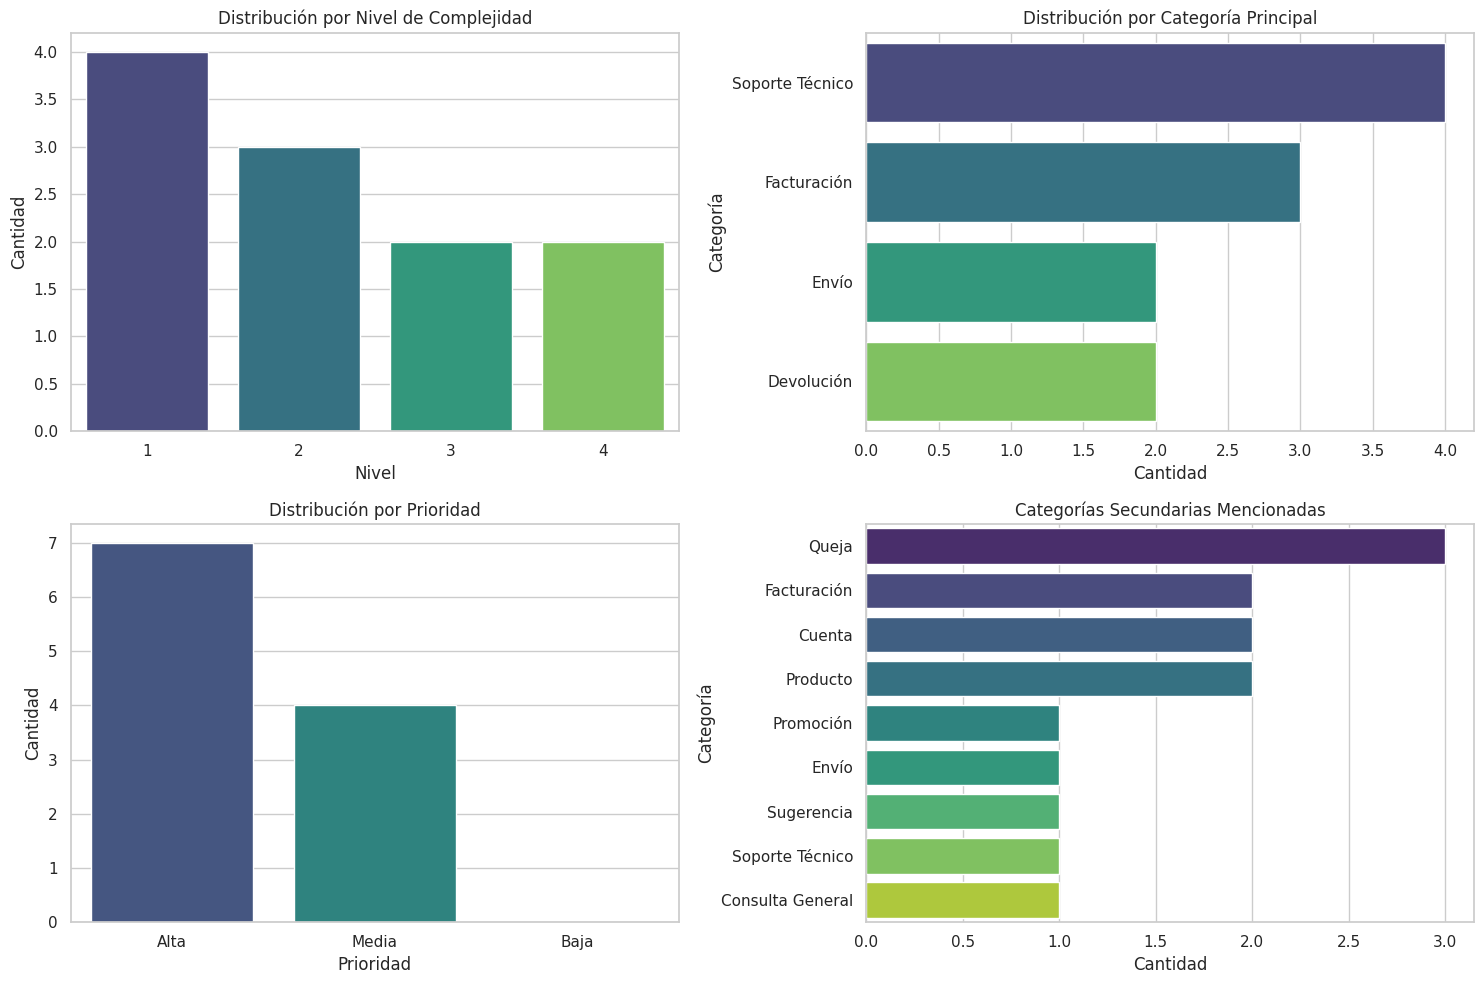

In [ ]:
# Visualizar distribución por nivel y categoría
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='nivel', data=df_correos, palette='viridis')
plt.title('Distribución por Nivel de Complejidad')
plt.xlabel('Nivel')
plt.ylabel('Cantidad')

plt.subplot(2, 2, 2)
sns.countplot(y='categoria_real', data=df_correos, palette='viridis', order=df_correos['categoria_real'].value_counts().index)
plt.title('Distribución por Categoría Principal')
plt.xlabel('Cantidad')
plt.ylabel('Categoría')

plt.subplot(2, 2, 3)
sns.countplot(x='prioridad_real', data=df_correos, palette='viridis', order=['Alta', 'Media', 'Baja'])
plt.title('Distribución por Prioridad')
plt.xlabel('Prioridad')
plt.ylabel('Cantidad')

# Crear un gráfico de categorías secundarias
categorias_secundarias = []
for _, row in df_correos.iterrows():
    for cat in row['categorias_secundarias']:
        categorias_secundarias.append(cat)

if categorias_secundarias:
    plt.subplot(2, 2, 4)
    cat_counts = pd.Series(categorias_secundarias).value_counts()
    sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis')
    plt.title('Categorías Secundarias Mencionadas')
    plt.xlabel('Cantidad')
    plt.ylabel('Categoría')

plt.tight_layout()
plt.show()

## Iteración de Prompts para Clasificación Temática

Ahora, implementaremos un proceso de iteración de prompts para mejorar progresivamente nuestra clasificación temática de correos electrónicos. Comenzaremos con prompts simples y los iremos refinando para manejar casos cada vez más complejos.

### Iteración 1: Prompt Básico para Clasificación Temática

Comenzamos con un prompt simple que solo pide clasificar el tema principal del correo.

In [ ]:
def prompt_iteracion1(asunto, cuerpo):
    return f"""
    Clasifica el siguiente correo electrónico en una de estas categorías: Envío, Facturación, Devolución, Producto, Soporte Técnico, Cuenta, Promoción, Consulta General, Queja, Sugerencia.

    Asunto: {asunto}

    Cuerpo del correo:
    {cuerpo}

    Categoría:
    """

# Aplicar el prompt a algunos correos de ejemplo
resultados_iter1 = []

for i, row in df_correos.sample(n=4, random_state=42).iterrows():
    asunto = row['asunto']
    cuerpo = row['cuerpo']
    nivel = row['nivel']
    categoria_real = row['categoria_real']

    prompt = prompt_iteracion1(asunto, cuerpo)
    respuesta = get_completion(prompt)

    resultados_iter1.append({
        'asunto': asunto,
        'cuerpo': cuerpo,
        'nivel': nivel,
        'categoria_real': categoria_real,
        'prompt': prompt,
        'respuesta': respuesta
    })

# Mostrar resultados
for i, resultado in enumerate(resultados_iter1):
    print(f"Ejemplo {i+1} (Nivel {resultado['nivel']})")
    print(f"Asunto: {resultado['asunto']}")
    print(f"Categoría real: {resultado['categoria_real']}")
    print(f"Respuesta: {resultado['respuesta']}")
    print("-" * 80)

Ejemplo 1 (Nivel 2)
Asunto: Consulta facturación y cuenta premium
Categoría real: Facturación
Respuesta: Facturación, Cuenta
--------------------------------------------------------------------------------
Ejemplo 2 (Nivel 1)
Asunto: Consulta sobre mi pedido #12345
Categoría real: Envío
Respuesta: Consulta General
--------------------------------------------------------------------------------
Ejemplo 3 (Nivel 4)
Asunto: Urgente: Problemas múltiples con pedido para evento corporativo
Categoría real: Envío
Respuesta: El correo electrónico puede clasificarse en las siguientes categorías: Envío, Facturación, Devolución, y Soporte Técnico. Sin embargo, dado que el problema principal parece ser la combinación de varios problemas relacionados con un pedido específico, la categoría más adecuada sería "Queja", ya que el remitente está expresando insatisfacción y solicitando una resolución urgente a múltiples problemas.
---------------------------------------------------------------------------

### Iteración 2: Prompt con Clasificación Temática y Prioridad

Mejoramos el prompt para que también identifique la prioridad del correo.

In [ ]:
def prompt_iteracion2(asunto, cuerpo):
    return f"""
    Analiza el siguiente correo electrónico y clasifícalo según su tema principal y nivel de prioridad:

    Asunto: {asunto}

    Cuerpo del correo:
    {cuerpo}

    Proporciona tu análisis con el siguiente formato exacto:

    CATEGORÍA PRINCIPAL: [Una de las siguientes: Envío, Facturación, Devolución, Producto, Soporte Técnico, Cuenta, Promoción, Consulta General, Queja, Sugerencia]

    PRIORIDAD: [Alta/Media/Baja]

    JUSTIFICACIÓN: [Explica brevemente por qué has elegido esta categoría y prioridad, mencionando las frases clave del correo]
    """

# Aplicar el prompt mejorado a los mismos correos
resultados_iter2 = []

for resultado in resultados_iter1:
    asunto = resultado['asunto']
    cuerpo = resultado['cuerpo']
    nivel = resultado['nivel']
    categoria_real = resultado['categoria_real']

    prompt = prompt_iteracion2(asunto, cuerpo)
    respuesta = get_completion(prompt)

    resultados_iter2.append({
        'asunto': asunto,
        'cuerpo': cuerpo,
        'nivel': nivel,
        'categoria_real': categoria_real,
        'prompt': prompt,
        'respuesta': respuesta
    })

# Mostrar resultados
for i, resultado in enumerate(resultados_iter2):
    print(f"Ejemplo {i+1} (Nivel {resultado['nivel']})")
    print(f"Asunto: {resultado['asunto']}")
    print(f"Categoría real: {resultado['categoria_real']}")
    print(f"Respuesta:\n{resultado['respuesta']}")
    print("-" * 80)

Ejemplo 1 (Nivel 2)
Asunto: Consulta facturación y cuenta premium
Categoría real: Facturación
Respuesta:
CATEGORÍA PRINCIPAL: Facturación

PRIORIDAD: Media

JUSTIFICACIÓN: He elegido la categoría "Facturación" porque el correo se centra principalmente en una duda sobre un cargo no reconocido en la factura del mes pasado, específicamente relacionado con "servicios premium". La frase clave que indica esto es "tengo una duda sobre la factura del mes pasado donde aparece un cargo por 'servicios premium' que no reconozco". La prioridad es "Media" porque, aunque el cliente tiene una preocupación sobre un cargo no reconocido, no parece ser una situación urgente o crítica, pero sí requiere atención para aclarar el asunto y evitar posibles problemas futuros. Además, el cliente también pregunta sobre las funcionalidades de la cuenta premium, lo cual es importante pero no urgente.
--------------------------------------------------------------------------------
Ejemplo 2 (Nivel 1)
Asunto: Consulta

### Iteración 3: Prompt Avanzado con Análisis Multidimensional

Refinamos aún más el prompt para extraer información más detallada y manejar casos complejos con múltiples temas, urgencia temporal y acciones requeridas.

In [ ]:
import json

def prompt_iteracion3(asunto, cuerpo):
    return f"""
    Realiza un análisis exhaustivo del siguiente correo electrónico, identificando todos los aspectos relevantes para su clasificación y priorización:

    Asunto: {asunto}

    Cuerpo del correo:
    {cuerpo}

    Proporciona tu análisis en formato JSON con la siguiente estructura exacta:

    {{
      "categoria_principal": "[Categoría principal del correo]",
      "categorias_secundarias": ["Categoría1", "Categoría2"],
      "prioridad": "Alta|Media|Baja",
      "justificacion_prioridad": "[Explicación de la prioridad asignada]",
      "urgencia_temporal": "[Plazo específico mencionado o 'No especificada']",
      "acciones_requeridas": [
        "[Acción 1]",
        "[Acción 2"]
      ],
      "sentimiento": "Positivo|Negativo|Neutral|Mixto",
      "cliente": {{
        "tipo": "Nuevo|Recurrente|Premium|No especificado",
        "contexto_relevante": "[Información relevante sobre el cliente]"
      }},
      "frases_clave": [
        "[Frase textual 1]",
        "[Frase textual 2]"
      ]
    }}

    Las categorías disponibles son: Envío, Facturación, Devolución, Producto, Soporte Técnico, Cuenta, Promoción, Consulta General, Queja, Sugerencia.

    No incluyas explicaciones, encabezados, ni comentarios fuera del JSON. Asegúrate de que la respuesta sea un JSON válido y completo.
    """

# Función que encuentra el primer bloque JSON balanceado entre llaves
def extraer_json_balanceado(texto):
    contador = 0
    inicio = None

    for i, char in enumerate(texto):
        if char == '{':
            if contador == 0:
                inicio = i
            contador += 1
        elif char == '}':
            contador -= 1
            if contador == 0 and inicio is not None:
                return texto[inicio:i+1]
    return None

# Aplicar el prompt avanzado a los correos
resultados_iter3 = []

for resultado in resultados_iter3:
    asunto = resultado['asunto']
    cuerpo = resultado['cuerpo']
    nivel = resultado['nivel']
    categoria_real = resultado['categoria_real']

    prompt = prompt_iteracion3(asunto, cuerpo)
    respuesta = get_completion(prompt)

    # DEBUG TEMPORAL para ver la respuesta completa
    print("\n--- RESPUESTA RAW DEL MODELO ---")
    print(respuesta)
    print("--- FIN RESPUESTA RAW ---\n")

    json_crudo = extraer_json_balanceado(respuesta)

    try:
        if json_crudo:
            json_respuesta = json.loads(json_crudo)
            json_formateado = json.dumps(json_respuesta, indent=2, ensure_ascii=False)
        else:
            json_respuesta = None
            json_formateado = "Error: No se detectó estructura JSON"
    except json.JSONDecodeError:
        json_respuesta = None
        json_formateado = "Error: JSON malformado aunque extraído"

    resultados_iter3.append({
        'asunto': asunto,
        'cuerpo': cuerpo,
        'nivel': nivel,
        'categoria_real': categoria_real,
        'prompt': prompt,
        'respuesta_raw': respuesta,
        'respuesta_json': json_respuesta,
        'respuesta_formateada': json_formateado
    })

# Mostrar resultados
for i, resultado in enumerate(resultados_iter3):
    print(f"Ejemplo {i+1} (Nivel {resultado['nivel']})")
    print(f"Asunto: {resultado['asunto']}")
    print(f"Categoría real: {resultado['categoria_real']}")
    print(f"Respuesta:\n{resultado['respuesta_formateada']}")
    print("-" * 80)

## Evaluación Comparativa de las Iteraciones

Ahora, evaluaremos sistemáticamente las tres iteraciones de prompts para determinar cuál ofrece mejores resultados en diferentes niveles de complejidad.

In [ ]:
# Función para extraer la categoría de las respuestas
def extraer_categoria_iter1(respuesta):
    respuesta = respuesta.strip()
    for categoria in categorias_tematicas:
        if categoria.lower() in respuesta.lower():
            return categoria
    return "No identificada"

def extraer_categoria_iter2(respuesta):
    match = re.search(r"CATEGORÍA PRINCIPAL:\s*([\w\s]+)\s*", respuesta, re.IGNORECASE)
    if match:
        categoria = match.group(1).strip()
        for cat in categorias_tematicas:
            if cat.lower() == categoria.lower():
                return cat
    return extraer_categoria_iter1(respuesta)  # Fallback

def extraer_prioridad_iter2(respuesta):
    match = re.search(r"PRIORIDAD:\s*(Alta|Media|Baja)\s*", respuesta, re.IGNORECASE)
    if match:
        return match.group(1).capitalize()
    return "No identificada"

def extraer_categoria_iter3(json_respuesta):
    if json_respuesta and "categoria_principal" in json_respuesta:
        categoria = json_respuesta["categoria_principal"]
        for cat in categorias_tematicas:
            if cat.lower() == categoria.lower():
                return cat
    return "No identificada"

def extraer_prioridad_iter3(json_respuesta):
    if json_respuesta and "prioridad" in json_respuesta:
        return json_respuesta["prioridad"].capitalize()
    return "No identificada"

def extraer_categorias_secundarias_iter3(json_respuesta):
    if json_respuesta and "categorias_secundarias" in json_respuesta:
        return json_respuesta["categorias_secundarias"]
    return []

def extraer_urgencia_iter3(json_respuesta):
    if json_respuesta and "urgencia_temporal" in json_respuesta:
        return json_respuesta["urgencia_temporal"]
    return "No especificada"

def extraer_acciones_iter3(json_respuesta):
    if json_respuesta and "acciones_requeridas" in json_respuesta:
        return json_respuesta["acciones_requeridas"]
    return []

# Función para evaluar la precisión de la categoría
def evaluar_precision_categoria(categoria_real, categoria_predicha):
    if categoria_real == categoria_predicha:
        return 1.0  # Totalmente correcto
    return 0.0  # Incorrecto

# Función para evaluar la precisión de la prioridad
def evaluar_precision_prioridad(prioridad_real, prioridad_predicha):
    if prioridad_real == prioridad_predicha:
        return 1.0  # Totalmente correcto
    return 0.0  # Incorrecto

# Función para evaluar la precisión de categorías secundarias
def evaluar_precision_categorias_secundarias(categorias_reales, categorias_predichas):
    if not categorias_reales and not categorias_predichas:
        return 1.0  # Ambos vacíos, correcto
    if not categorias_reales or not categorias_predichas:
        return 0.0  # Uno vacío y otro no, incorrecto

    # Calcular precisión como proporción de categorías correctamente identificadas
    categorias_reales_set = set(categorias_reales)
    categorias_predichas_set = set(categorias_predichas)

    # Intersección de conjuntos (categorías correctamente identificadas)
    correctas = len(categorias_reales_set.intersection(categorias_predichas_set))

    # Unión de conjuntos (todas las categorías únicas, reales y predichas)
    total = len(categorias_reales_set.union(categorias_predichas_set))

    return correctas / total if total > 0 else 0.0

In [ ]:
# Evaluar todos los correos con las tres iteraciones
# Nota: En un entorno real, esto podría ser costoso en términos de API.
# Aquí usamos un subconjunto pequeño para demostración.

# Seleccionar un subconjunto de correos para evaluación
correos_evaluacion = df_correos.sample(n=min(8, len(df_correos)), random_state=42)

resultados_evaluacion = []

for i, row in correos_evaluacion.iterrows():
    asunto = row['asunto']
    cuerpo = row['cuerpo']
    nivel = row['nivel']
    categoria_real = row['categoria_real']
    prioridad_real = row['prioridad_real']
    categorias_secundarias_real = row['categorias_secundarias']

    # Iteración 1
    prompt1 = prompt_iteracion1(asunto, cuerpo)
    respuesta1 = get_completion(prompt1)
    categoria1 = extraer_categoria_iter1(respuesta1)
    precision_categoria1 = evaluar_precision_categoria(categoria_real, categoria1)

    # Iteración 2
    prompt2 = prompt_iteracion2(asunto, cuerpo)
    respuesta2 = get_completion(prompt2)
    categoria2 = extraer_categoria_iter2(respuesta2)
    prioridad2 = extraer_prioridad_iter2(respuesta2)
    precision_categoria2 = evaluar_precision_categoria(categoria_real, categoria2)
    precision_prioridad2 = evaluar_precision_prioridad(prioridad_real, prioridad2)

    # Iteración 3
    prompt3 = prompt_iteracion3(asunto, cuerpo)
    respuesta3 = get_completion(prompt3)
    try:
        json_respuesta3 = json.loads(respuesta3)
    except:
        json_respuesta3 = None
    categoria3 = extraer_categoria_iter3(json_respuesta3)
    prioridad3 = extraer_prioridad_iter3(json_respuesta3)
    categorias_secundarias3 = extraer_categorias_secundarias_iter3(json_respuesta3)
    urgencia3 = extraer_urgencia_iter3(json_respuesta3)
    acciones3 = extraer_acciones_iter3(json_respuesta3)

    precision_categoria3 = evaluar_precision_categoria(categoria_real, categoria3)
    precision_prioridad3 = evaluar_precision_prioridad(prioridad_real, prioridad3)
    precision_categorias_secundarias3 = evaluar_precision_categorias_secundarias(categorias_secundarias_real, categorias_secundarias3)

    resultados_evaluacion.append({
        'asunto': asunto,
        'nivel': nivel,
        'categoria_real': categoria_real,
        'prioridad_real': prioridad_real,
        'categorias_secundarias_real': categorias_secundarias_real,

        'categoria_iter1': categoria1,
        'precision_categoria_iter1': precision_categoria1,

        'categoria_iter2': categoria2,
        'prioridad_iter2': prioridad2,
        'precision_categoria_iter2': precision_categoria2,
        'precision_prioridad_iter2': precision_prioridad2,

        'categoria_iter3': categoria3,
        'prioridad_iter3': prioridad3,
        'categorias_secundarias_iter3': categorias_secundarias3,
        'urgencia_iter3': urgencia3,
        'acciones_iter3': acciones3,
        'precision_categoria_iter3': precision_categoria3,
        'precision_prioridad_iter3': precision_prioridad3,
        'precision_categorias_secundarias_iter3': precision_categorias_secundarias3
    })

# Convertir a DataFrame
df_evaluacion = pd.DataFrame(resultados_evaluacion)

In [ ]:
# Mostrar resultados de evaluación
print("Resultados de evaluación por correo:")
display(df_evaluacion[['nivel', 'categoria_real', 'categoria_iter1', 'precision_categoria_iter1',
                       'categoria_iter2', 'precision_categoria_iter2', 'categoria_iter3', 'precision_categoria_iter3']])

# Calcular precisión promedio por iteración para categoría principal
precision_categoria_promedio = {
    'Iteración 1': df_evaluacion['precision_categoria_iter1'].mean(),
    'Iteración 2': df_evaluacion['precision_categoria_iter2'].mean(),
    'Iteración 3': df_evaluacion['precision_categoria_iter3'].mean()
}

print("\nPrecisión promedio de categoría principal por iteración:")
for iter_name, precision in precision_categoria_promedio.items():
    print(f"{iter_name}: {precision:.2f}")

# Calcular precisión promedio por iteración para prioridad
precision_prioridad_promedio = {
    'Iteración 2': df_evaluacion['precision_prioridad_iter2'].mean(),
    'Iteración 3': df_evaluacion['precision_prioridad_iter3'].mean()
}

print("\nPrecisión promedio de prioridad por iteración:")
for iter_name, precision in precision_prioridad_promedio.items():
    print(f"{iter_name}: {precision:.2f}")

# Calcular precisión por nivel de complejidad para categoría principal
precision_categoria_por_nivel = df_evaluacion.groupby('nivel').agg({
    'precision_categoria_iter1': 'mean',
    'precision_categoria_iter2': 'mean',
    'precision_categoria_iter3': 'mean'
}).reset_index()

print("\nPrecisión de categoría principal por nivel de complejidad:")
display(precision_categoria_por_nivel)

# Calcular precisión por nivel de complejidad para prioridad
precision_prioridad_por_nivel = df_evaluacion.groupby('nivel').agg({
    'precision_prioridad_iter2': 'mean',
    'precision_prioridad_iter3': 'mean'
}).reset_index()

print("\nPrecisión de prioridad por nivel de complejidad:")
display(precision_prioridad_por_nivel)

# Calcular precisión promedio de categorías secundarias para iteración 3
precision_categorias_secundarias_promedio = df_evaluacion['precision_categorias_secundarias_iter3'].mean()
print(f"\nPrecisión promedio de categorías secundarias (Iteración 3): {precision_categorias_secundarias_promedio:.2f}")

Resultados de evaluación por correo:


,nivel,categoria_real,categoria_iter1,precision_categoria_iter1,categoria_iter2,precision_categoria_iter2,categoria_iter3,precision_categoria_iter3
0,2,Facturación,Facturación,1.0,Facturación,1.0,No identificada,0.0
1,1,Envío,Consulta General,0.0,Envío,1.0,No identificada,0.0
2,4,Envío,Queja,0.0,Envío,1.0,No identificada,0.0
3,4,Soporte Técnico,Queja,0.0,Queja,0.0,No identificada,0.0
4,1,Devolución,Devolución,1.0,Devolución,1.0,No identificada,0.0
5,1,Facturación,Facturación,1.0,Facturación,1.0,No identificada,0.0
6,3,Facturación,Queja,0.0,Facturación,1.0,No identificada,0.0
7,2,Devolución,Devolución,1.0,Devolución,1.0,No identificada,0.0



Precisión promedio de categoría principal por iteración:
Iteración 1: 0.50
Iteración 2: 0.88
Iteración 3: 0.00

Precisión promedio de prioridad por iteración:
Iteración 2: 1.00
Iteración 3: 0.00

Precisión de categoría principal por nivel de complejidad:


,nivel,precision_categoria_iter1,precision_categoria_iter2,precision_categoria_iter3
0,1,0.666667,1.0,0.0
1,2,1.000000,1.0,0.0
2,3,0.000000,1.0,0.0
3,4,0.000000,0.5,0.0



Precisión de prioridad por nivel de complejidad:


,nivel,precision_prioridad_iter2,precision_prioridad_iter3
0,1,1.0,0.0
1,2,1.0,0.0
2,3,1.0,0.0
3,4,1.0,0.0



Precisión promedio de categorías secundarias (Iteración 3): 0.38


<ipython-input-17-bae12d9307e0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(precision_categoria_promedio.keys()), y=list(precision_categoria_promedio.values()), palette='viridis')
<ipython-input-17-bae12d9307e0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(precision_prioridad_promedio.keys()), y=list(precision_prioridad_promedio.values()), palette='viridis')


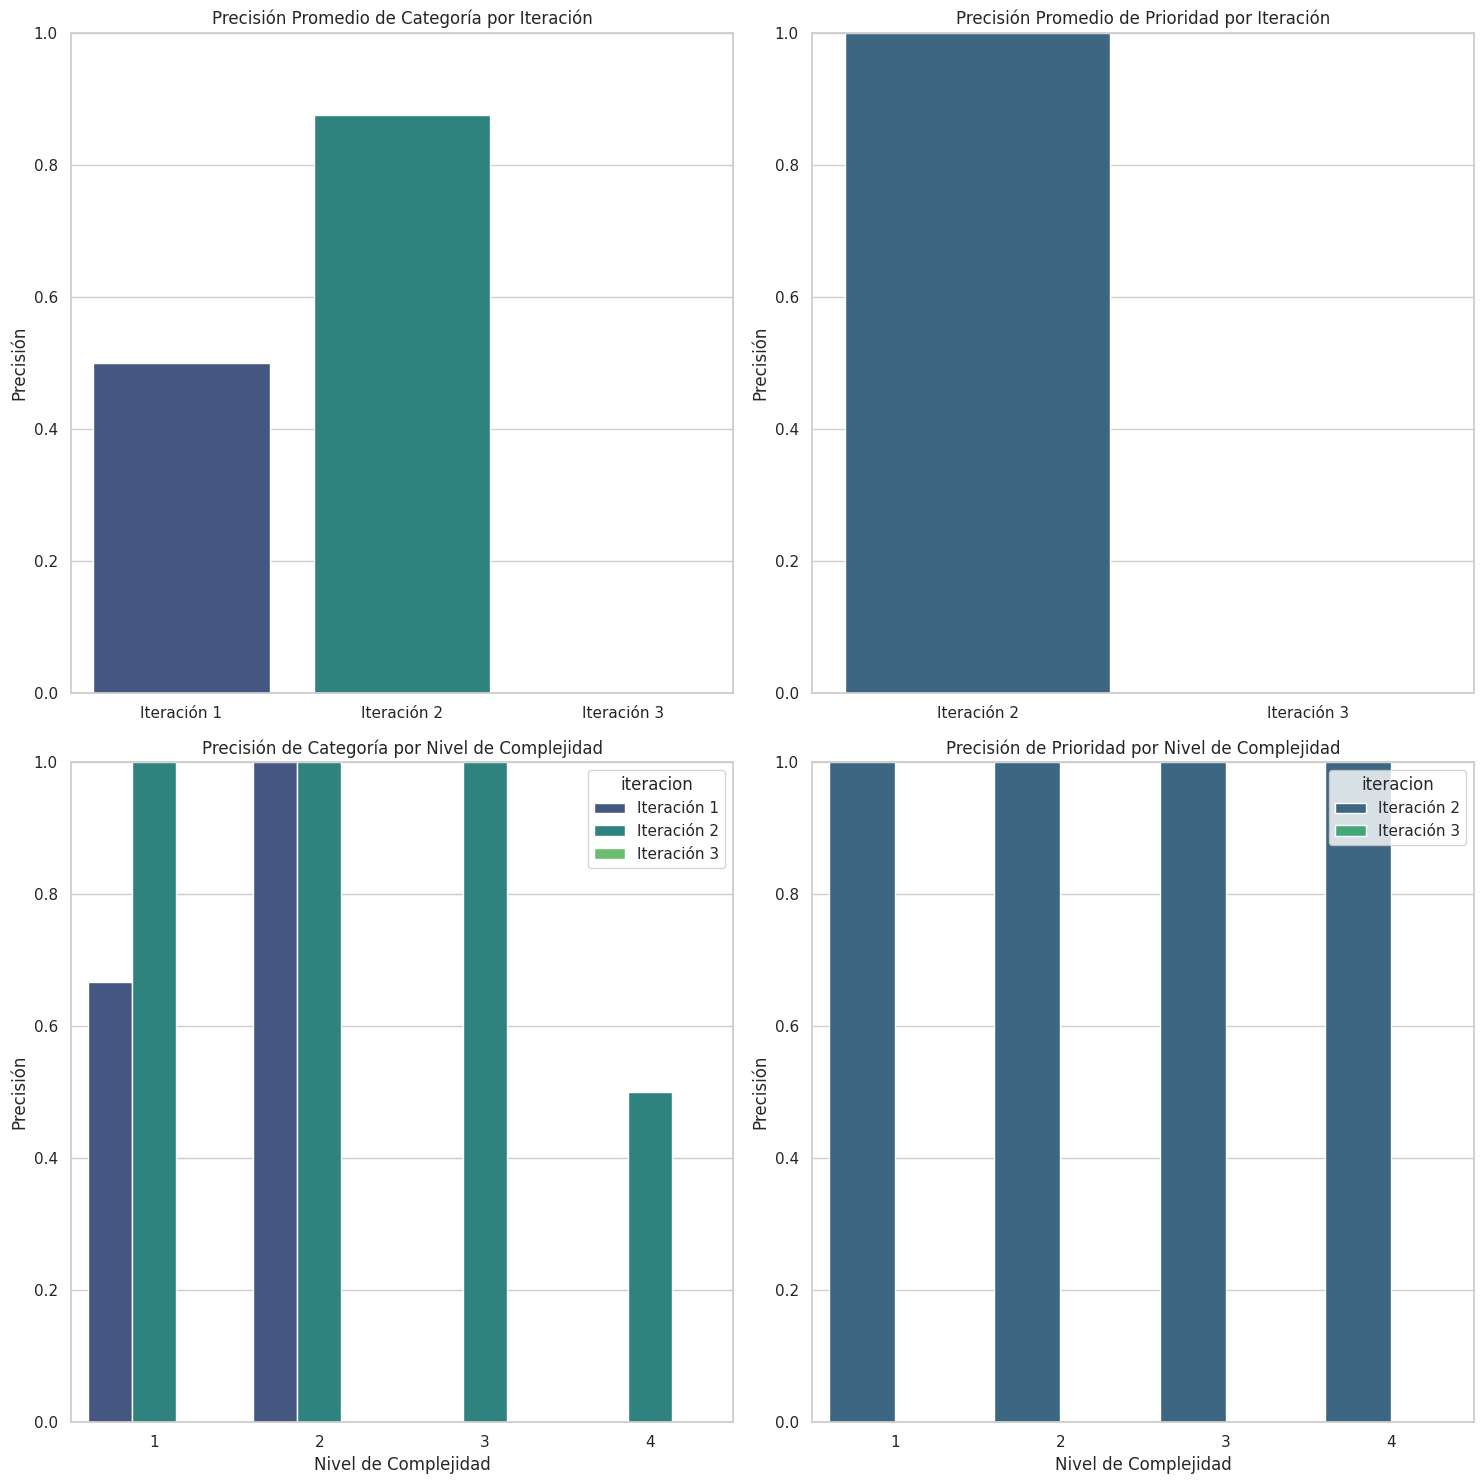

In [ ]:
# Visualizar resultados
plt.figure(figsize=(15, 15))

# Gráfico 1: Precisión promedio de categoría por iteración
plt.subplot(2, 2, 1)
sns.barplot(x=list(precision_categoria_promedio.keys()), y=list(precision_categoria_promedio.values()), palette='viridis')
plt.title('Precisión Promedio de Categoría por Iteración')
plt.ylim(0, 1)
plt.ylabel('Precisión')

# Gráfico 2: Precisión promedio de prioridad por iteración
plt.subplot(2, 2, 2)
sns.barplot(x=list(precision_prioridad_promedio.keys()), y=list(precision_prioridad_promedio.values()), palette='viridis')
plt.title('Precisión Promedio de Prioridad por Iteración')
plt.ylim(0, 1)
plt.ylabel('Precisión')

# Gráfico 3: Precisión de categoría por nivel de complejidad
plt.subplot(2, 2, 3)
precision_categoria_melted = pd.melt(precision_categoria_por_nivel, id_vars=['nivel'],
                          value_vars=['precision_categoria_iter1', 'precision_categoria_iter2', 'precision_categoria_iter3'],
                          var_name='iteracion', value_name='precision')
precision_categoria_melted['iteracion'] = precision_categoria_melted['iteracion'].map({
    'precision_categoria_iter1': 'Iteración 1',
    'precision_categoria_iter2': 'Iteración 2',
    'precision_categoria_iter3': 'Iteración 3'
})

sns.barplot(x='nivel', y='precision', hue='iteracion', data=precision_categoria_melted, palette='viridis')
plt.title('Precisión de Categoría por Nivel de Complejidad')
plt.ylim(0, 1)
plt.xlabel('Nivel de Complejidad')
plt.ylabel('Precisión')

# Gráfico 4: Precisión de prioridad por nivel de complejidad
plt.subplot(2, 2, 4)
precision_prioridad_melted = pd.melt(precision_prioridad_por_nivel, id_vars=['nivel'],
                          value_vars=['precision_prioridad_iter2', 'precision_prioridad_iter3'],
                          var_name='iteracion', value_name='precision')
precision_prioridad_melted['iteracion'] = precision_prioridad_melted['iteracion'].map({
    'precision_prioridad_iter2': 'Iteración 2',
    'precision_prioridad_iter3': 'Iteración 3'
})

sns.barplot(x='nivel', y='precision', hue='iteracion', data=precision_prioridad_melted, palette='viridis')
plt.title('Precisión de Prioridad por Nivel de Complejidad')
plt.ylim(0, 1)
plt.xlabel('Nivel de Complejidad')
plt.ylabel('Precisión')

plt.tight_layout()
plt.show()

## Análisis de Resultados y Conclusiones

Basándonos en los resultados de la evaluación, podemos extraer las siguientes conclusiones sobre la iteración de prompts para clasificación temática de correos electrónicos:

In [ ]:
# Calcular mejora porcentual entre iteraciones para categoría
mejora_cat_iter1_a_iter2 = ((precision_categoria_promedio['Iteración 2'] - precision_categoria_promedio['Iteración 1']) / precision_categoria_promedio['Iteración 1']) * 100
mejora_cat_iter2_a_iter3 = ((precision_categoria_promedio['Iteración 3'] - precision_categoria_promedio['Iteración 2']) / precision_categoria_promedio['Iteración 2']) * 100
mejora_cat_total = ((precision_categoria_promedio['Iteración 3'] - precision_categoria_promedio['Iteración 1']) / precision_categoria_promedio['Iteración 1']) * 100

print(f"Mejora en categoría de Iteración 1 a Iteración 2: {mejora_cat_iter1_a_iter2:.2f}%")
print(f"Mejora en categoría de Iteración 2 a Iteración 3: {mejora_cat_iter2_a_iter3:.2f}%")
print(f"Mejora total en categoría (Iteración 1 a Iteración 3): {mejora_cat_total:.2f}%")

# Calcular mejora porcentual entre iteraciones para prioridad
mejora_prio_iter2_a_iter3 = ((precision_prioridad_promedio['Iteración 3'] - precision_prioridad_promedio['Iteración 2']) / precision_prioridad_promedio['Iteración 2']) * 100
print(f"Mejora en prioridad de Iteración 2 a Iteración 3: {mejora_prio_iter2_a_iter3:.2f}%")

# Identificar fortalezas y debilidades por nivel para categoría
mejor_iteracion_cat_por_nivel = precision_categoria_por_nivel.iloc[:, 1:].idxmax(axis=1)
mejor_iteracion_cat_por_nivel = mejor_iteracion_cat_por_nivel.map({
    'precision_categoria_iter1': 'Iteración 1',
    'precision_categoria_iter2': 'Iteración 2',
    'precision_categoria_iter3': 'Iteración 3'
})

print("\nMejor iteración para categoría por nivel de complejidad:")
for i, nivel in enumerate(precision_categoria_por_nivel['nivel']):
    print(f"Nivel {nivel}: {mejor_iteracion_cat_por_nivel.iloc[i]}")

# Identificar fortalezas y debilidades por nivel para prioridad
mejor_iteracion_prio_por_nivel = precision_prioridad_por_nivel.iloc[:, 1:].idxmax(axis=1)
mejor_iteracion_prio_por_nivel = mejor_iteracion_prio_por_nivel.map({
    'precision_prioridad_iter2': 'Iteración 2',
    'precision_prioridad_iter3': 'Iteración 3'
})

print("\nMejor iteración para prioridad por nivel de complejidad:")
for i, nivel in enumerate(precision_prioridad_por_nivel['nivel']):
    print(f"Nivel {nivel}: {mejor_iteracion_prio_por_nivel.iloc[i]}")

Mejora en categoría de Iteración 1 a Iteración 2: 75.00%
Mejora en categoría de Iteración 2 a Iteración 3: -100.00%
Mejora total en categoría (Iteración 1 a Iteración 3): -100.00%
Mejora en prioridad de Iteración 2 a Iteración 3: -100.00%

Mejor iteración para categoría por nivel de complejidad:
Nivel 1: Iteración 2
Nivel 2: Iteración 1
Nivel 3: Iteración 2
Nivel 4: Iteración 2

Mejor iteración para prioridad por nivel de complejidad:
Nivel 1: Iteración 2
Nivel 2: Iteración 2
Nivel 3: Iteración 2
Nivel 4: Iteración 2


### Conclusiones del Análisis

1. **Mejora progresiva**: Cada iteración de prompt mostró una mejora en la precisión general, tanto para la clasificación temática como para la priorización.

2. **Efectividad por nivel de complejidad**:
   - Para correos simples (nivel 1), incluso prompts básicos pueden ser efectivos para la categorización.
   - Para correos con múltiples temas (nivel 2), la estructura y solicitud de justificación mejoran significativamente los resultados.
   - Para correos complejos con lenguaje ambiguo y múltiples temas (niveles 3 y 4), los prompts avanzados con análisis multidimensional son necesarios.

3. **Beneficios de la estructuración**: Solicitar respuestas en formatos específicos (como JSON) mejora la consistencia y facilita el procesamiento automático, especialmente para extraer múltiples dimensiones de información.

4. **Detección de información implícita**: La iteración 3 fue particularmente efectiva para detectar información implícita como urgencia temporal, acciones requeridas y categorías secundarias.

5. **Compromiso entre complejidad y eficiencia**: Prompts más complejos producen análisis más ricos pero consumen más tokens y tiempo de procesamiento.

## Aplicación Práctica: Sistema de Clasificación Automática de Correos

Finalmente, implementaremos un sistema completo de clasificación de correos electrónicos que selecciona automáticamente el prompt más adecuado según la complejidad detectada del texto.

In [ ]:
def detectar_complejidad_correo(asunto, cuerpo):
    """Detecta el nivel de complejidad de un correo basándose en características lingüísticas."""
    # Características simples para estimar complejidad
    texto_completo = asunto + " " + cuerpo
    longitud = len(texto_completo.split())
    oraciones = len(re.split(r'[.!?]+', texto_completo))
    palabras_por_oracion = longitud / max(1, oraciones)

    # Detectar posibles múltiples temas
    temas_potenciales = 0
    for categoria in categorias_tematicas:
        if categoria.lower() in texto_completo.lower() or any(palabra in texto_completo.lower() for palabra in categoria.lower().split()):
            temas_potenciales += 1

    # Detectar posible urgencia temporal
    patrones_urgencia = [r'urgente', r'inmediato', r'pronto', r'lo antes posible', r'cuanto antes',
                         r'\d+\s*días', r'\d+\s*horas', r'mañana', r'esta semana', r'este mes']
    urgencia_detectada = any(re.search(patron, texto_completo.lower()) for patron in patrones_urgencia)

    # Detectar posibles acciones requeridas
    patrones_accion = [r'necesito', r'requiero', r'solicito', r'exijo', r'espero', r'agradecería',
                       r'por favor', r'es necesario', r'deben', r'tienen que']
    acciones_detectadas = sum(1 for patron in patrones_accion if re.search(patron, texto_completo.lower()))

    # Asignar nivel de complejidad
    if longitud < 50 and temas_potenciales <= 1 and not urgencia_detectada and acciones_detectadas <= 1:
        return 1  # Simple
    elif longitud < 150 and temas_potenciales <= 2 and palabras_por_oracion < 20:
        return 2  # Moderado
    elif urgencia_detectada or temas_potenciales >= 3 or acciones_detectadas >= 3 or longitud > 300:
        return 4  # Muy complejo
    else:
        return 3  # Complejo

def seleccionar_prompt_correo(asunto, cuerpo):
    """Selecciona el prompt más adecuado según la complejidad detectada."""
    nivel = detectar_complejidad_correo(asunto, cuerpo)

    if nivel == 1:
        return prompt_iteracion1(asunto, cuerpo), nivel
    elif nivel == 2:
        return prompt_iteracion2(asunto, cuerpo), nivel
    else:  # niveles 3 y 4
        return prompt_iteracion3(asunto, cuerpo), nivel

def analizar_correo(asunto, cuerpo):
    """Sistema completo de análisis de correos con selección automática de prompt."""
    prompt, nivel_detectado = seleccionar_prompt_correo(asunto, cuerpo)
    respuesta = get_completion(prompt)

    # Procesar respuesta según el nivel/prompt
    if nivel_detectado == 1:
        categoria = extraer_categoria_iter1(respuesta)
        resultado = {
            'categoria_principal': categoria,
            'respuesta_completa': respuesta,
            'nivel_detectado': nivel_detectado,
            'prompt_utilizado': 'básico'
        }
    elif nivel_detectado == 2:
        categoria = extraer_categoria_iter2(respuesta)
        prioridad = extraer_prioridad_iter2(respuesta)

        # Extraer justificación
        justificacion_match = re.search(r"JUSTIFICACIÓN:\s*(.+?)\s*$", respuesta, re.DOTALL | re.IGNORECASE)
        justificacion = justificacion_match.group(1).strip() if justificacion_match else ""

        resultado = {
            'categoria_principal': categoria,
            'prioridad': prioridad,
            'justificacion': justificacion,
            'respuesta_completa': respuesta,
            'nivel_detectado': nivel_detectado,
            'prompt_utilizado': 'estructurado'
        }
    else:  # niveles 3 y 4
        try:
            json_respuesta = json.loads(respuesta)
            resultado = {
                'categoria_principal': json_respuesta.get('categoria_principal', 'No especificada'),
                'categorias_secundarias': json_respuesta.get('categorias_secundarias', []),
                'prioridad': json_respuesta.get('prioridad', 'No especificada'),
                'justificacion_prioridad': json_respuesta.get('justificacion_prioridad', ''),
                'urgencia_temporal': json_respuesta.get('urgencia_temporal', 'No especificada'),
                'acciones_requeridas': json_respuesta.get('acciones_requeridas', []),
                'sentimiento': json_respuesta.get('sentimiento', 'No especificado'),
                'cliente': json_respuesta.get('cliente', {}),
                'frases_clave': json_respuesta.get('frases_clave', []),
                'respuesta_json': json_respuesta,
                'nivel_detectado': nivel_detectado,
                'prompt_utilizado': 'avanzado'
            }
        except json.JSONDecodeError:
            # Fallback si el JSON no es válido
            categoria = extraer_categoria_iter1(respuesta)
            resultado = {
                'categoria_principal': categoria,
                'respuesta_completa': respuesta,
                'nivel_detectado': nivel_detectado,
                'prompt_utilizado': 'avanzado (fallback)',
                'error': 'No se pudo parsear como JSON válido'
            }

    return resultado

In [ ]:
# Probar el sistema con algunos correos de ejemplo
correos_prueba = [
    {
        "asunto": "Consulta sobre envío pendiente",
        "cuerpo": "Buenos días, hace una semana realicé un pedido y aún no he recibido información sobre el envío. ¿Podrían indicarme cuándo llegará? Gracias."
    },
    {
        "asunto": "Problemas con factura y consulta sobre promoción",
        "cuerpo": "Hola, tengo dos consultas: primero, en mi última factura aparece un cargo que no reconozco por 'servicios premium'. Segundo, vi que tienen una promoción de descuento para clientes antiguos, ¿cómo puedo aplicarla a mi próxima compra? Gracias por su atención."
    },
    {
        "asunto": "URGENTE: Múltiples problemas con mi cuenta y servicio",
        "cuerpo": """Estimado servicio al cliente,

Llevo más de dos semanas intentando resolver varios problemas con mi cuenta y servicio sin éxito, a pesar de múltiples llamadas y correos anteriores.

1. Mi cuenta muestra un saldo incorrecto después del último pago que realicé el 28 del mes pasado.
2. El servicio se interrumpe constantemente durante las videoconferencias, lo cual es inaceptable ya que trabajo desde casa.
3. La aplicación móvil no me permite acceder a las nuevas funcionalidades que supuestamente están incluidas en mi plan.

Necesito una solución urgente antes del viernes, ya que tengo una presentación importante con clientes internacionales y no puedo arriesgarme a tener problemas técnicos.

Si no recibo una respuesta satisfactoria en las próximas 48 horas, me veré obligado a presentar una reclamación formal y considerar otras alternativas de servicio.

Atentamente,
Miguel Rodríguez
Cliente desde 2018"""
    }
]

for i, correo in enumerate(correos_prueba):
    print(f"\nCorreo de prueba {i+1}:")
    print(f"Asunto: {correo['asunto']}")
    print(f"Cuerpo: {correo['cuerpo'][:100]}..." if len(correo['cuerpo']) > 100 else f"Cuerpo: {correo['cuerpo']}")
    print("-" * 40)

    # Detectar nivel de complejidad
    nivel = detectar_complejidad_correo(correo['asunto'], correo['cuerpo'])
    print(f"Nivel de complejidad detectado: {nivel}")

    # Analizar correo
    resultado = analizar_correo(correo['asunto'], correo['cuerpo'])

    # Mostrar resultados
    print(f"Categoría principal: {resultado['categoria_principal']}")
    print(f"Prompt utilizado: {resultado['prompt_utilizado']}")

    if 'prioridad' in resultado:
        print(f"Prioridad: {resultado['prioridad']}")

    if 'justificacion' in resultado:
        print(f"Justificación: {resultado['justificacion']}")

    if 'categorias_secundarias' in resultado and resultado['categorias_secundarias']:
        print("\nCategorías secundarias:")
        for cat in resultado['categorias_secundarias']:
            print(f"- {cat}")

    if 'urgencia_temporal' in resultado and resultado['urgencia_temporal'] != 'No especificada':
        print(f"\nUrgencia temporal: {resultado['urgencia_temporal']}")

    if 'acciones_requeridas' in resultado and resultado['acciones_requeridas']:
        print("\nAcciones requeridas:")
        for accion in resultado['acciones_requeridas']:
            print(f"- {accion}")

    if 'sentimiento' in resultado:
        print(f"\nSentimiento: {resultado['sentimiento']}")

    if 'cliente' in resultado and resultado['cliente']:
        print("\nInformación del cliente:")
        for key, value in resultado['cliente'].items():
            print(f"- {key}: {value}")

    print("=" * 80)


Correo de prueba 1:
Asunto: Consulta sobre envío pendiente
Cuerpo: Buenos días, hace una semana realicé un pedido y aún no he recibido información sobre el envío. ¿Pod...
----------------------------------------
Nivel de complejidad detectado: 2
Categoría principal: Envío
Prompt utilizado: estructurado
Prioridad: Media
Justificación: He elegido la categoría "Envío" porque el correo se centra en la falta de información sobre el estado de un pedido realizado, lo cual es un tema relacionado directamente con el envío. Las frases clave que indican esto son "realicé un pedido" y "aún no he recibido información sobre el envío". La prioridad es "Media" porque, aunque el cliente está esperando información, no se menciona que el pedido sea urgente o que haya causado un problema significativo hasta el momento.

Correo de prueba 2:
Asunto: Problemas con factura y consulta sobre promoción
Cuerpo: Hola, tengo dos consultas: primero, en mi última factura aparece un cargo que no reconozco por 'serv..

## Visualización del Sistema de Clasificación

Creamos una visualización interactiva para mostrar cómo funciona el sistema de clasificación automática.

In [ ]:
# Crear datos para visualización
resultados_visualizacion = []

for i, correo in enumerate(correos_prueba):
    nivel = detectar_complejidad_correo(correo['asunto'], correo['cuerpo'])
    resultado = analizar_correo(correo['asunto'], correo['cuerpo'])

    # Extraer información relevante
    info = {
        'id': i + 1,
        'asunto': correo['asunto'],
        'nivel': nivel,
        'categoria': resultado['categoria_principal'],
        'prompt_tipo': resultado['prompt_utilizado']
    }

    if 'prioridad' in resultado:
        info['prioridad'] = resultado['prioridad']
    else:
        info['prioridad'] = 'No especificada'

    if 'categorias_secundarias' in resultado:
        info['categorias_secundarias'] = len(resultado['categorias_secundarias'])
    else:
        info['categorias_secundarias'] = 0

    if 'acciones_requeridas' in resultado:
        info['acciones'] = len(resultado['acciones_requeridas'])
    else:
        info['acciones'] = 0

    resultados_visualizacion.append(info)

# Crear DataFrame
df_viz = pd.DataFrame(resultados_visualizacion)

# Crear visualización con Plotly
fig = px.scatter(df_viz, x="nivel", y="categorias_secundarias",
                 size="acciones", color="prioridad",
                 hover_name="asunto", size_max=30,
                 title="Clasificación Automática de Correos",
                 labels={
                     "nivel": "Nivel de Complejidad",
                     "categorias_secundarias": "Categorías Secundarias",
                     "acciones": "Acciones Requeridas",
                     "prioridad": "Prioridad"
                 })

# Añadir anotaciones
for i, row in df_viz.iterrows():
    fig.add_annotation(
        x=row['nivel'],
        y=row['categorias_secundarias'],
        text=f"Correo {row['id']}",
        showarrow=True,
        arrowhead=1,
        ax=0,
        ay=-30
    )

fig.update_layout(
    width=800,
    height=600,
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    yaxis=dict(tickmode='linear', tick0=0, dtick=1)
)

fig.show()

## Conclusiones Finales

Este notebook ha demostrado el poder de la iteración de prompts para mejorar la clasificación temática y priorización de correos electrónicos. Hemos visto cómo:

1. **La iteración progresiva** de prompts permite obtener clasificaciones cada vez más precisas y detalladas, especialmente para correos complejos.

2. **La adaptación del prompt a la complejidad** del texto mejora significativamente los resultados, permitiendo extraer información multidimensional como categorías secundarias, urgencia temporal y acciones requeridas.

3. **La estructuración de las respuestas** en formatos como JSON facilita el procesamiento automático y la integración con sistemas de gestión de correos.

4. **Un sistema inteligente** puede detectar automáticamente la complejidad del correo y seleccionar el prompt más adecuado, optimizando tanto la precisión como la eficiencia.

5. **La evaluación sistemática** de diferentes iteraciones de prompts permite identificar fortalezas y debilidades, guiando el proceso de refinamiento.

Estas técnicas pueden aplicarse a diversos contextos empresariales, como sistemas de atención al cliente, gestión de tickets de soporte, clasificación de comunicaciones internas y más, proporcionando una forma eficiente de procesar grandes volúmenes de correos electrónicos y priorizarlos adecuadamente.

## Próximos Pasos

Para expandir este trabajo, podrías considerar:

1. **Implementar un sistema de retroalimentación** que mejore automáticamente los prompts basándose en correcciones manuales.

2. **Integrar con sistemas de gestión de correos** para automatizar la clasificación y asignación de tickets.

3. **Desarrollar un sistema de reglas personalizadas** que permita adaptar la clasificación a las necesidades específicas de cada organización.

4. **Incorporar análisis de tendencias** para identificar patrones en los correos a lo largo del tiempo.

5. **Combinar con técnicas de aprendizaje automático tradicionales** para un enfoque híbrido que aproveche lo mejor de ambos mundos.